## Deeper into DeepTrain
This example assumes you've read `basic.ipynb`, and covers:
   - Multi-phase training
       - Changing loss & hyperparameters between phases
   - Callback streaming images to directory
   - Saving & loading
   - Variable-layer model building

In [1]:
import os
import sys
from pathlib import Path
os.environ['TF_KERAS'] = '1'
sys.path.insert(0, str(Path(Path.cwd()).parent))
sys.path.insert(0, os.path.join(Path(Path.cwd()).parents[1], "see-rnn"))

from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Model

from pathlib import Path
from deeptrain import TrainGenerator, DataGenerator
from deeptrain.callbacks import VizAE2D

### Configuration

In [2]:
# This scheme enables variable number of layers
def make_model(batch_shape, optimizer, loss, metrics,
               filters, kernel_size, strides, activation, up_sampling_2d,
               input_dropout, preout_dropout):
    """Compressing, denoising AutoEncoder."""
    ipt = Input(batch_shape=batch_shape)
    x   = Dropout(input_dropout)(ipt)

    configs = (activation, filters, kernel_size, strides, up_sampling_2d)
    for a, f, ks, s, ups in zip(*configs):
        x = UpSampling2D(ups)(x) if ups else x
        x = Conv2D(f, ks, strides=s, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation(a)(x)

    x   = Dropout(preout_dropout)(x)
    x   = Conv2D(1, (3, 3), strides=1, padding='same', activation='sigmoid')(x)
    out = x

    model = Model(ipt, out)
    model.compile(optimizer, loss, metrics=metrics)
    return model

In [3]:
batch_size = 128
width, height, channels = 28, 28, 1
# 28x compression
MODEL_CFG = dict(
    batch_shape=(batch_size, width, height, channels),
    loss='mse',
    metrics=None,
    optimizer='nadam',
    activation=['relu'] * 5,
    filters=[6, 12, 2, 6, 12],
    kernel_size=[(3, 3)] * 5,
    strides=[(2, 2), (2, 2), 1, 1, 1],
    up_sampling_2d=[None, None, None, (2, 2), (2, 2)],
    input_dropout=.5,
    preout_dropout=.4,
)
datadir = os.path.join("dir", "data", "image")
DATAGEN_CFG = dict(
    data_path=os.path.join(datadir, 'train'),
    batch_size=batch_size,
    shuffle=True,
    superbatch_set_nums='all',
)
VAL_DATAGEN_CFG = dict(
    data_path=os.path.join(datadir, 'val'),
    batch_size=batch_size,
    shuffle=False,
    superbatch_set_nums='all',
)

- `key_metric`: the metric that decides the "best" model
- `max_is_best`: whether greater `key_metric` is better (we seek to minimize loss)
- `input_as_labels`: y = x, or model.fit(x, x)
- `eval_fn`: function to use in validation
- `val_freq`:               how often to validate     (default: every epoch)
- `plot_history_freq`:      how often to plot history (default: every epoch)
- `unique_checkpoint_freq`: how often to checkpoint   (default: every epoch)
- `model_save_kw`: kwargs passed to `model.save()`. Exclude optimizer since we'll save its (and model's)<br> weights separately to load later
- `model_name_configs`: set which model attributes to include in automatic name generation, and their (shortened) aliases

In [4]:
TRAINGEN_CFG = dict(
    epochs=6,
    logs_dir=os.path.join('dir', 'outputs', 'logs'),
    best_models_dir=os.path.join('dir', 'outputs', 'models'),
    model_configs=MODEL_CFG,
    key_metric='mae',
    max_is_best=False,
    input_as_labels=True,
    eval_fn='predict',
    val_freq={'epoch': 2},
    plot_history_freq={'epoch': 2},
    unique_checkpoint_freq={'epoch': 2},
    model_save_kw=dict(include_optimizer=False, save_format='h5'),
    model_name_configs=dict(input_dropout='idp', preout_dropout='pdp',
                            optimizer='', lr='', best_key_metric=None)
)

### Create visualization callback

In [5]:
TRAINGEN_CFG['callbacks'] = [VizAE2D(n_images=8, save_images=True)]

### Create training objects

In [6]:
model = make_model(**MODEL_CFG)
dg    = DataGenerator(**DATAGEN_CFG)
vdg   = DataGenerator(**VAL_DATAGEN_CFG)
tg    = TrainGenerator(model, dg, vdg, **TRAINGEN_CFG)

# save optimizer weights & attrs to load later
_ = tg.saveskip_list.pop(tg.saveskip_list.index('optimizer_state'))

Discovered 50 files with matching format
50 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
Discovered 36 files with matching format
36 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
NOTE: will exclude `labels` from saving when `input_as_labels=True`; to keep 'labels', add '{labels}'to `saveskip_list` instead
Preloading superbatch ... WARNING: multiple file extensions found in `path`; only .npy will be used 
Discovered 50 files with matching format
.................................................. finished, w/ 6400 total samples
Train initial data prepared
Preloading superbatch ... WARNING: multiple file extensions found in `path`; only .npy will be used 
Discovered 36 files with matching format
.................................... finished, w/ 4608 total sample

### Train


Fitting set 1...   Loss = 0.260898 
Fitting set 2...   Loss = 0.256504 
Fitting set 3...   Loss = 0.252751 
Fitting set 4...   Loss = 0.249103 
Fitting set 5...   Loss = 0.245866 
Fitting set 6...   Loss = 0.242623 
Fitting set 7...   Loss = 0.239488 
Fitting set 8...   Loss = 0.236393 
Fitting set 9...   Loss = 0.233416 
Fitting set 10...  Loss = 0.230390 
Fitting set 11...  Loss = 0.227412 
Fitting set 12...  Loss = 0.224400 
Fitting set 13...  Loss = 0.221536 
Fitting set 14...  Loss = 0.218498 
Fitting set 15...  Loss = 0.215499 
Fitting set 16...  Loss = 0.212736 
Fitting set 17...  Loss = 0.209936 
Fitting set 18...  Loss = 0.207135 
Fitting set 19...  Loss = 0.204382 
Fitting set 20...  Loss = 0.201681 
Fitting set 21...  Loss = 0.199024 
Fitting set 22...  Loss = 0.196473 
Fitting set 23...  Loss = 0.193976 
Fitting set 24...  Loss = 0.191452 
Fitting set 25...  Loss = 0.189001 
Fitting set 26...  Loss = 0.186614 
Fitting set 27...  Loss = 0.184339 
Fitting set 28...  Loss = 0

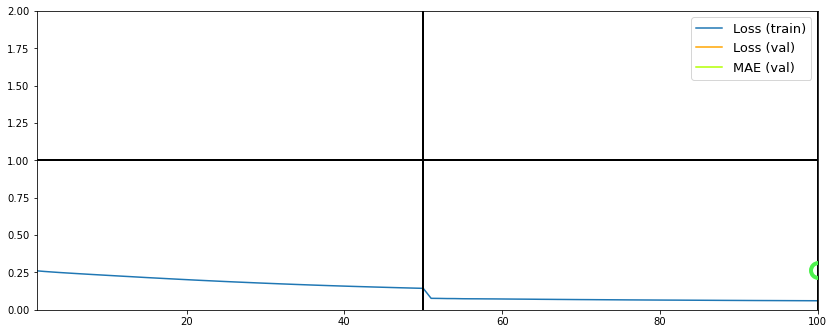

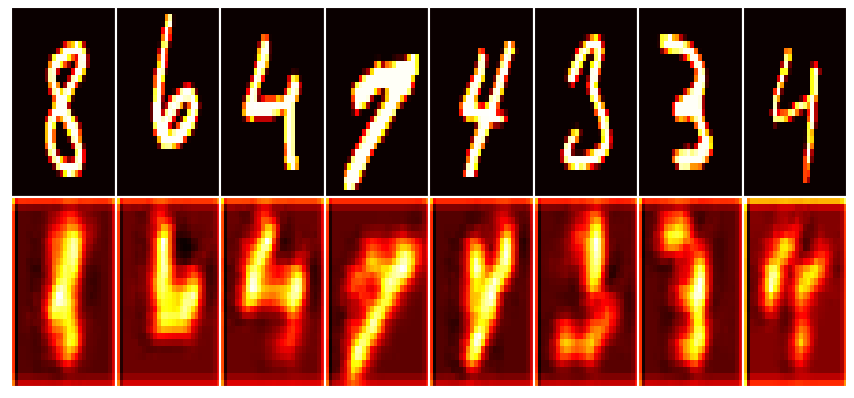


Fitting set 7...   Loss = 0.050055 
Fitting set 25...  Loss = 0.049834 
Fitting set 8...   Loss = 0.050446 
Fitting set 16...  Loss = 0.050030 
Fitting set 3...   Loss = 0.050241 
Fitting set 30...  Loss = 0.050150 
Fitting set 35...  Loss = 0.050129 
Fitting set 4...   Loss = 0.049983 
Fitting set 34...  Loss = 0.049762 
Fitting set 9...   Loss = 0.049607 
Fitting set 19...  Loss = 0.049455 
Fitting set 12...  Loss = 0.049361 
Fitting set 17...  Loss = 0.049216 
Fitting set 26...  Loss = 0.049037 
Fitting set 29...  Loss = 0.048942 
Fitting set 46...  Loss = 0.048706 
Fitting set 22...  Loss = 0.048565 
Fitting set 31...  Loss = 0.048456 
Fitting set 10...  Loss = 0.048360 
Fitting set 14...  Loss = 0.048286 
Fitting set 36...  Loss = 0.048172 
Fitting set 45...  Loss = 0.048062 
Fitting set 41...  Loss = 0.048023 
Fitting set 43...  Loss = 0.048020 
Fitting set 32...  Loss = 0.047898 
Fitting set 20...  Loss = 0.047806 
Fitting set 6...   Loss = 0.047682 
Fitting set 23...  Loss = 0

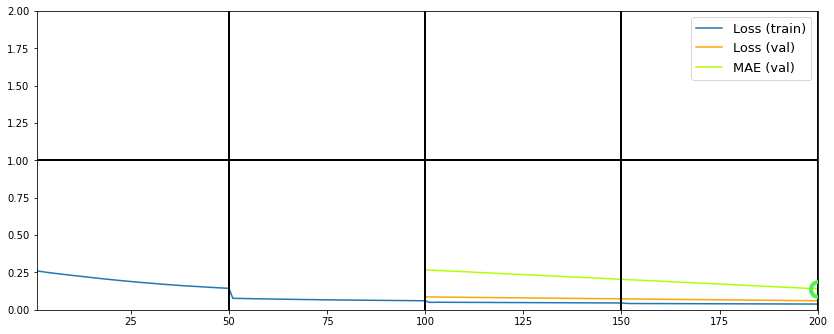

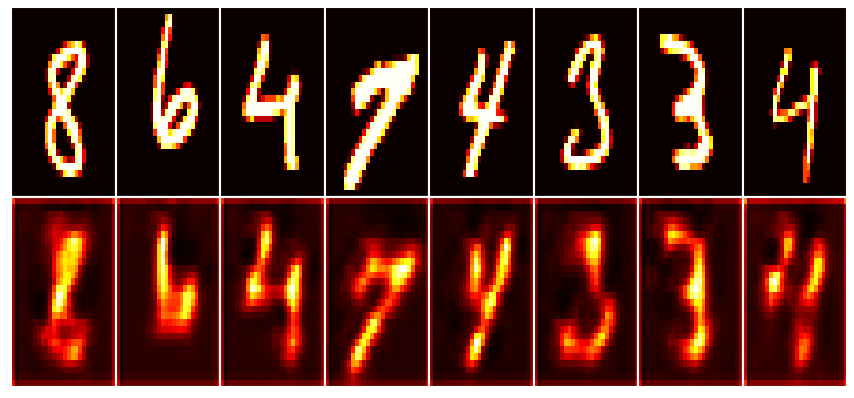


Fitting set 34...  Loss = 0.034654 
Fitting set 47...  Loss = 0.034543 
Fitting set 42...  Loss = 0.034675 
Fitting set 40...  Loss = 0.035083 
Fitting set 32...  Loss = 0.034859 
Fitting set 36...  Loss = 0.034760 
Fitting set 10...  Loss = 0.034643 
Fitting set 21...  Loss = 0.034340 
Fitting set 12...  Loss = 0.034335 
Fitting set 13...  Loss = 0.034300 
Fitting set 49...  Loss = 0.034235 
Fitting set 2...   Loss = 0.034279 
Fitting set 41...  Loss = 0.034307 
Fitting set 20...  Loss = 0.034246 
Fitting set 43...  Loss = 0.034259 
Fitting set 23...  Loss = 0.034210 
Fitting set 16...  Loss = 0.034102 
Fitting set 45...  Loss = 0.034049 
Fitting set 7...   Loss = 0.033978 
Fitting set 31...  Loss = 0.033879 
Fitting set 24...  Loss = 0.033716 
Fitting set 18...  Loss = 0.033652 
Fitting set 33...  Loss = 0.033586 
Fitting set 1...   Loss = 0.033554 
Fitting set 38...  Loss = 0.033486 
Fitting set 17...  Loss = 0.033453 
Fitting set 6...   Loss = 0.033381 
Fitting set 9...   Loss = 0

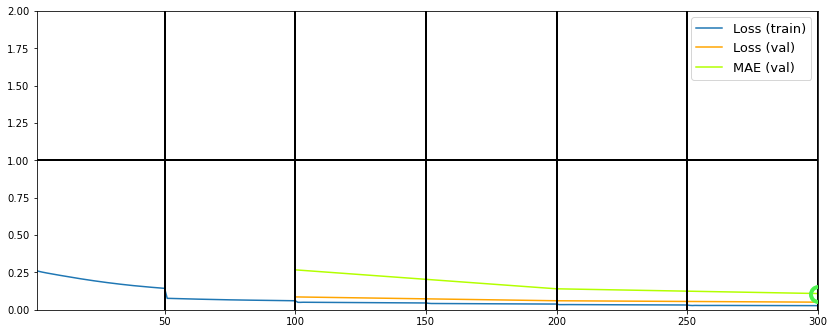

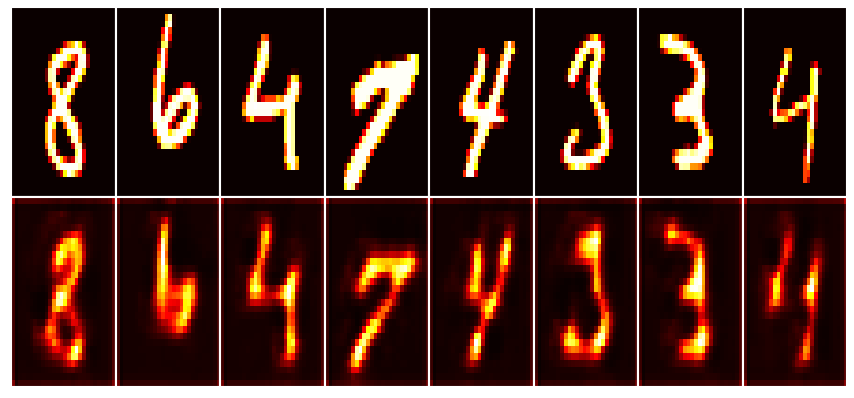

Training has concluded.


In [7]:
tg.train()

### Phase 2
Switch to *mean absolute error* loss; greater penalty to smaller errors forces better image resolution. <br>
Internally, TrainGenerator will append `'mae'` loss to same list as was `'mse'`.


Fitting set 18...  Loss = 0.079646 
Fitting set 10...  Loss = 0.078701 
Fitting set 16...  Loss = 0.077878 
Fitting set 45...  Loss = 0.077583 
Fitting set 42...  Loss = 0.077323 
Fitting set 21...  Loss = 0.076426 
Fitting set 22...  Loss = 0.076087 
Fitting set 46...  Loss = 0.075344 
Fitting set 7...   Loss = 0.074992 
Fitting set 43...  Loss = 0.074959 
Fitting set 13...  Loss = 0.074531 
Fitting set 35...  Loss = 0.074190 
Fitting set 27...  Loss = 0.073926 
Fitting set 6...   Loss = 0.073499 
Fitting set 28...  Loss = 0.073145 
Fitting set 26...  Loss = 0.072656 
Fitting set 19...  Loss = 0.072259 
Fitting set 34...  Loss = 0.071896 
Fitting set 36...  Loss = 0.071548 
Fitting set 40...  Loss = 0.071342 
Fitting set 17...  Loss = 0.071034 
Fitting set 39...  Loss = 0.070812 
Fitting set 44...  Loss = 0.070545 
Fitting set 20...  Loss = 0.070203 
Fitting set 5...   Loss = 0.069981 
Fitting set 32...  Loss = 0.069638 
Fitting set 24...  Loss = 0.069257 
Fitting set 12...  Loss = 0

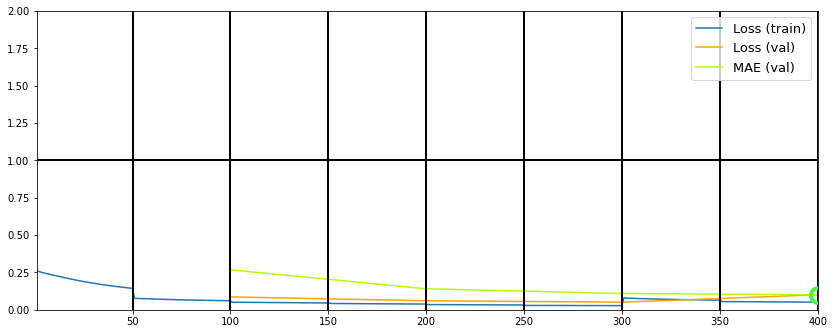

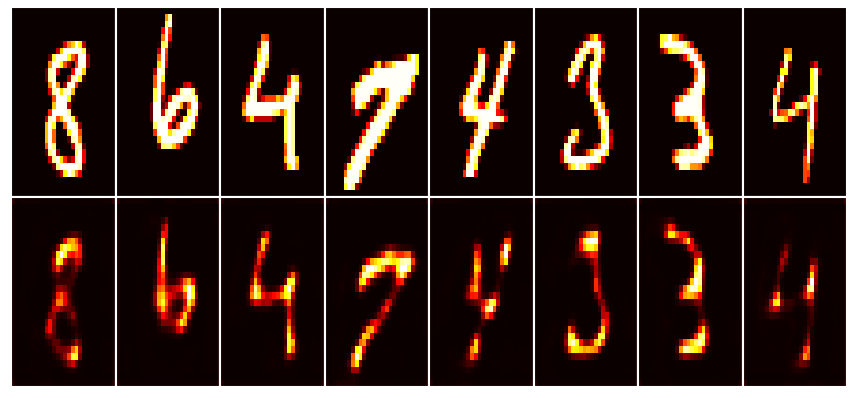


Fitting set 8...   Loss = 0.048824 
Fitting set 18...  Loss = 0.048732 
Fitting set 29...  Loss = 0.047931 
Fitting set 20...  Loss = 0.047763 
Fitting set 39...  Loss = 0.048178 
Fitting set 49...  Loss = 0.048342 
Fitting set 14...  Loss = 0.048101 
Fitting set 42...  Loss = 0.048227 
Fitting set 31...  Loss = 0.048032 
Fitting set 34...  Loss = 0.048016 
Fitting set 19...  Loss = 0.047961 
Fitting set 45...  Loss = 0.047907 
Fitting set 24...  Loss = 0.047677 
Fitting set 12...  Loss = 0.047658 
Fitting set 26...  Loss = 0.047449 
Fitting set 50...  Loss = 0.047293 
Fitting set 23...  Loss = 0.047274 
Fitting set 3...   Loss = 0.047358 
Fitting set 41...  Loss = 0.047381 
Fitting set 11...  Loss = 0.047420 
Fitting set 48...  Loss = 0.047423 
Fitting set 16...  Loss = 0.047362 
Fitting set 13...  Loss = 0.047335 
Fitting set 38...  Loss = 0.047323 
Fitting set 15...  Loss = 0.047246 
Fitting set 33...  Loss = 0.047175 
Fitting set 17...  Loss = 0.047151 
Fitting set 5...   Loss = 0

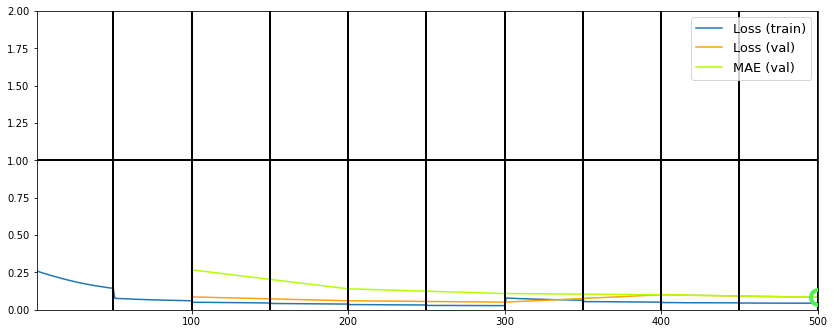

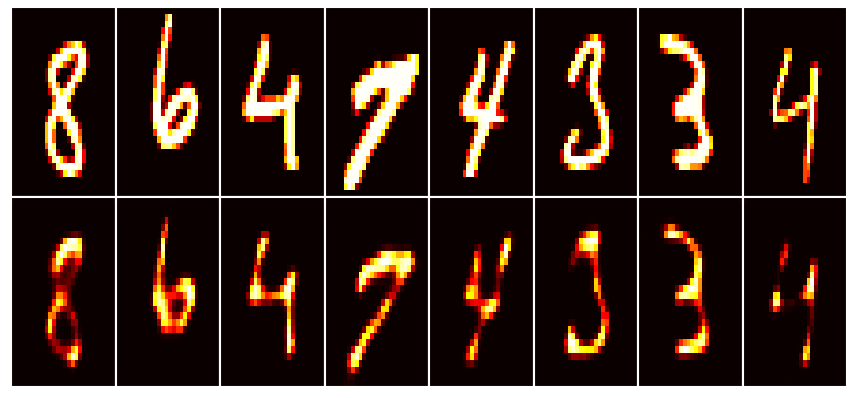


Fitting set 32...  Loss = 0.042194 
Fitting set 39...  Loss = 0.043820 
Fitting set 10...  Loss = 0.043665 
Fitting set 19...  Loss = 0.043255 
Fitting set 44...  Loss = 0.043389 
Fitting set 12...  Loss = 0.043149 
Fitting set 18...  Loss = 0.043146 
Fitting set 3...   Loss = 0.043205 
Fitting set 35...  Loss = 0.043273 
Fitting set 8...   Loss = 0.043289 
Fitting set 40...  Loss = 0.043355 
Fitting set 43...  Loss = 0.043548 
Fitting set 26...  Loss = 0.043304 
Fitting set 21...  Loss = 0.043118 
Fitting set 42...  Loss = 0.043147 
Fitting set 1...   Loss = 0.043117 
Fitting set 41...  Loss = 0.043128 
Fitting set 45...  Loss = 0.043139 
Fitting set 11...  Loss = 0.043180 
Fitting set 31...  Loss = 0.043155 
Fitting set 7...   Loss = 0.043169 
Fitting set 17...  Loss = 0.043132 
Fitting set 37...  Loss = 0.043054 
Fitting set 27...  Loss = 0.043066 
Fitting set 15...  Loss = 0.042997 
Fitting set 16...  Loss = 0.042958 
Fitting set 38...  Loss = 0.042952 
Fitting set 14...  Loss = 0

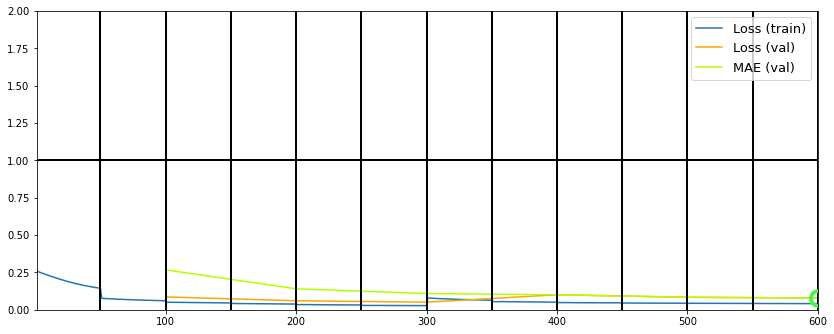

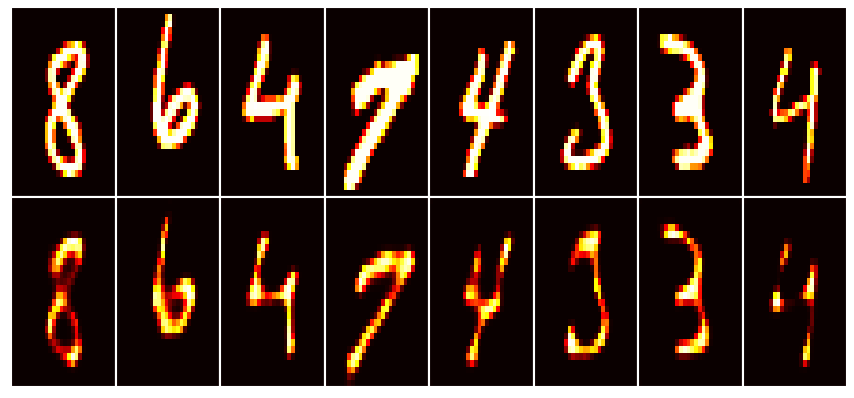

Training has concluded.


In [8]:
tg.model.compile(MODEL_CFG['optimizer'], 'mae')
tg.epochs = 12
tg.train()

### New session w/ changed hyperparams

In [12]:
# get best save's model weights & TrainGenerator state
latest_best_weights = tg.get_last_log('weights', best=True)
latest_best_state   = tg.get_last_log('state',   best=True)

# destroy existing train objects
tg.destroy(confirm=True)
del model, dg, vdg, tg

# increase preout_dropout to strengthen regularization
MODEL_CFG['preout_dropout'] = .7
MODEL_CFG['loss'] = 'mae'
# `epochs` will load at 12, so need to increase
TRAINGEN_CFG['epochs'] = 20
TRAINGEN_CFG['loadpath'] = latest_best_state
# ensure model_name uses prev model_num + 1, since using new hyperparams
TRAINGEN_CFG['new_model_num'] = False
# must re-instantiate callbacks object to hold new TrainGenerator
TRAINGEN_CFG['callbacks'] = [VizAE2D(n_images=8, save_images=True)]

### Create new train objects

In [13]:
model = make_model(**MODEL_CFG)
model.load_weights(latest_best_weights)

dg    = DataGenerator(**DATAGEN_CFG)
vdg   = DataGenerator(**VAL_DATAGEN_CFG)
tg    = TrainGenerator(model, dg, vdg, **TRAINGEN_CFG)
# can also load via `tg.load`, but passing in `loadpath` and starting a
# new session should work better

Discovered 50 files with matching format
50 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
Discovered 36 files with matching format
36 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated
NOTE: will exclude `labels` from saving when `input_as_labels=True`; to keep 'labels', add '{labels}'to `saveskip_list` instead
Optimizer state loaded (& cleared from TrainGenerator)
TrainGenerator state loaded from dir\outputs\models\M29__model-idp.5-pdp.4-nadam__min.079__state.h5
--Preloading excluded data based on datagen states ...
Preloading superbatch ... WARNING: multiple file extensions found in `path`; only .npy will be used 
Discovered 50 files with matching format
.................................................. finished, w/ 6400 total samples
Train initial data prepared

### Train


Fitting set 1...   Loss = 0.046457 
Fitting set 2...   Loss = 0.047331 
Fitting set 3...   Loss = 0.047497 
Fitting set 4...   Loss = 0.047313 
Fitting set 5...   Loss = 0.047469 
Fitting set 6...   Loss = 0.047210 
Fitting set 7...   Loss = 0.047131 
Fitting set 8...   Loss = 0.047073 
Fitting set 9...   Loss = 0.047176 
Fitting set 10...  Loss = 0.047061 
Fitting set 11...  Loss = 0.047209 
Fitting set 12...  Loss = 0.047112 
Fitting set 13...  Loss = 0.047002 
Fitting set 14...  Loss = 0.046905 
Fitting set 15...  Loss = 0.046793 
Fitting set 16...  Loss = 0.046765 
Fitting set 17...  Loss = 0.046768 
Fitting set 18...  Loss = 0.046708 
Fitting set 19...  Loss = 0.046631 
Fitting set 20...  Loss = 0.046530 
Fitting set 21...  Loss = 0.046365 
Fitting set 22...  Loss = 0.046361 
Fitting set 23...  Loss = 0.046338 
Fitting set 24...  Loss = 0.046193 
Fitting set 25...  Loss = 0.046113 
Fitting set 26...  Loss = 0.046012 
Fitting set 27...  Loss = 0.046020 
Fitting set 28...  Loss = 0

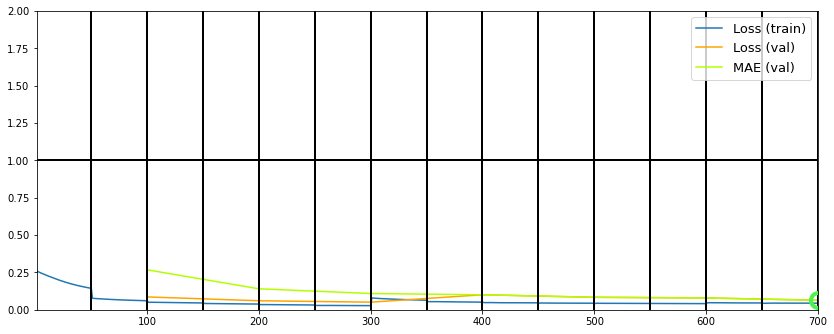

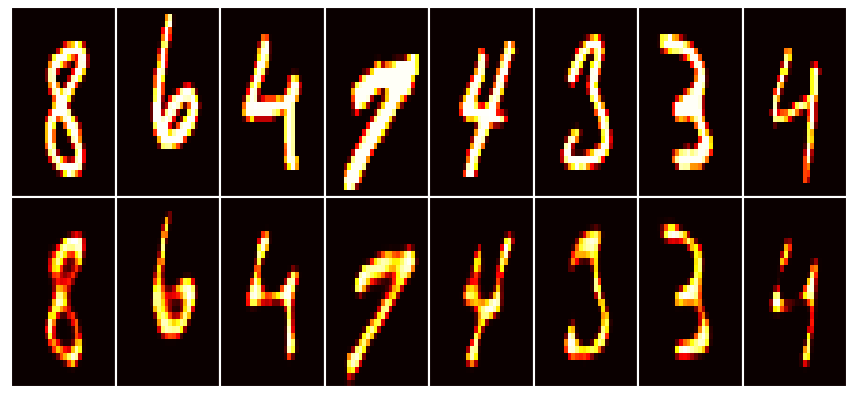


Fitting set 34...  Loss = 0.043233 
Fitting set 46...  Loss = 0.042578 
Fitting set 4...   Loss = 0.043191 
Fitting set 27...  Loss = 0.043502 
Fitting set 29...  Loss = 0.043169 
Fitting set 38...  Loss = 0.043280 
Fitting set 31...  Loss = 0.043341 
Fitting set 19...  Loss = 0.043329 
Fitting set 48...  Loss = 0.043395 
Fitting set 50...  Loss = 0.043255 
Fitting set 33...  Loss = 0.043297 
Fitting set 5...   Loss = 0.043464 
Fitting set 36...  Loss = 0.043419 
Fitting set 11...  Loss = 0.043525 
Fitting set 10...  Loss = 0.043530 
Fitting set 39...  Loss = 0.043620 
Fitting set 35...  Loss = 0.043653 
Fitting set 37...  Loss = 0.043588 
Fitting set 17...  Loss = 0.043595 
Fitting set 14...  Loss = 0.043579 
Fitting set 22...  Loss = 0.043593 
Fitting set 9...   Loss = 0.043659 
Fitting set 21...  Loss = 0.043521 
Fitting set 28...  Loss = 0.043515 
Fitting set 43...  Loss = 0.043573 
Fitting set 41...  Loss = 0.043590 
Fitting set 18...  Loss = 0.043565 
Fitting set 45...  Loss = 0

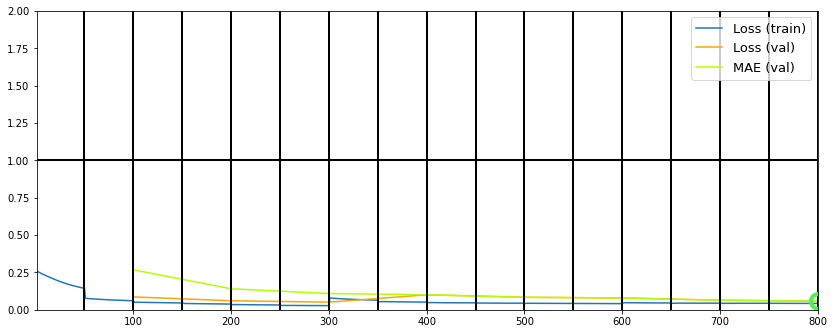

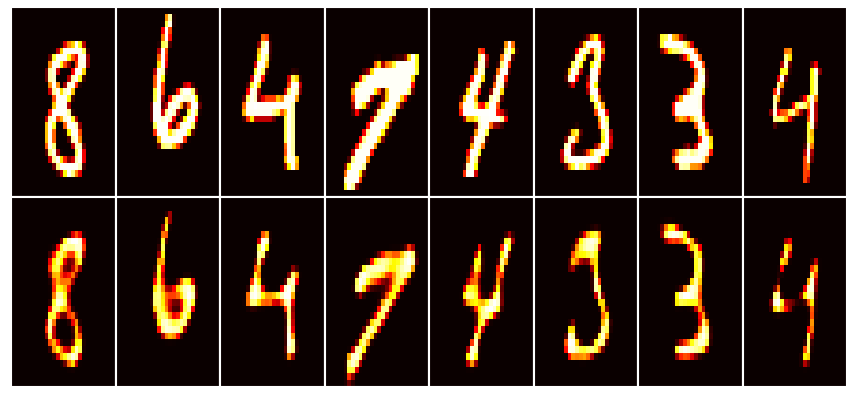


Fitting set 19...  Loss = 0.041554 
Fitting set 49...  Loss = 0.042391 
Fitting set 41...  Loss = 0.042569 
Fitting set 45...  Loss = 0.042582 
Fitting set 18...  Loss = 0.042393 
Fitting set 24...  Loss = 0.041938 
Fitting set 14...  Loss = 0.042067 
Fitting set 20...  Loss = 0.042021 
Fitting set 21...  Loss = 0.041787 
Fitting set 39...  Loss = 0.041998 
Fitting set 44...  Loss = 0.042085 
Fitting set 31...  Loss = 0.042043 
Fitting set 11...  Loss = 0.042149 
Fitting set 10...  Loss = 0.042196 
Fitting set 37...  Loss = 0.042063 
Fitting set 3...   Loss = 0.042096 
Fitting set 6...   Loss = 0.042049 
Fitting set 5...   Loss = 0.042137 
Fitting set 46...  Loss = 0.042075 
Fitting set 22...  Loss = 0.042071 
Fitting set 35...  Loss = 0.042122 
Fitting set 16...  Loss = 0.042114 
Fitting set 23...  Loss = 0.042116 
Fitting set 12...  Loss = 0.042093 
Fitting set 15...  Loss = 0.042089 
Fitting set 9...   Loss = 0.042149 
Fitting set 50...  Loss = 0.042103 
Fitting set 25...  Loss = 0

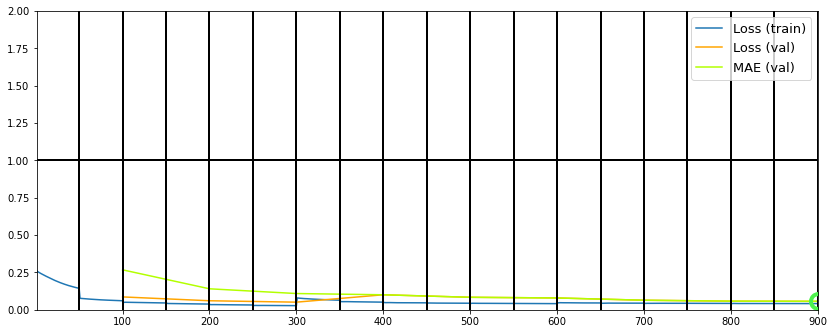

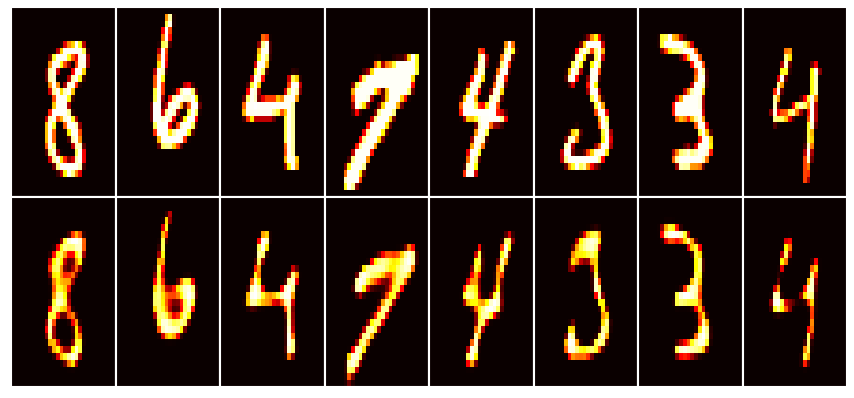


Fitting set 2...   Loss = 0.041898 
Fitting set 26...  Loss = 0.040455 
Fitting set 27...  Loss = 0.041187 
Fitting set 29...  Loss = 0.040887 
Fitting set 11...  Loss = 0.041394 
Fitting set 17...  Loss = 0.041344 
Fitting set 25...  Loss = 0.041202 
Fitting set 20...  Loss = 0.041099 
Fitting set 50...  Loss = 0.041021 
Fitting set 22...  Loss = 0.041044 
Fitting set 12...  Loss = 0.040999 
Fitting set 5...   Loss = 0.041109 
Fitting set 41...  Loss = 0.041140 
Fitting set 30...  Loss = 0.041248 
Fitting set 16...  Loss = 0.041219 
Fitting set 8...   Loss = 0.041241 
Fitting set 43...  Loss = 0.041316 
Fitting set 23...  Loss = 0.041312 
Fitting set 42...  Loss = 0.041337 
Fitting set 6...   Loss = 0.041315 
Fitting set 9...   Loss = 0.041433 
Fitting set 45...  Loss = 0.041432 
Fitting set 33...  Loss = 0.041394 
Fitting set 10...  Loss = 0.041402 
Fitting set 15...  Loss = 0.041374 
Fitting set 31...  Loss = 0.041352 
Fitting set 7...   Loss = 0.041362 
Fitting set 37...  Loss = 0

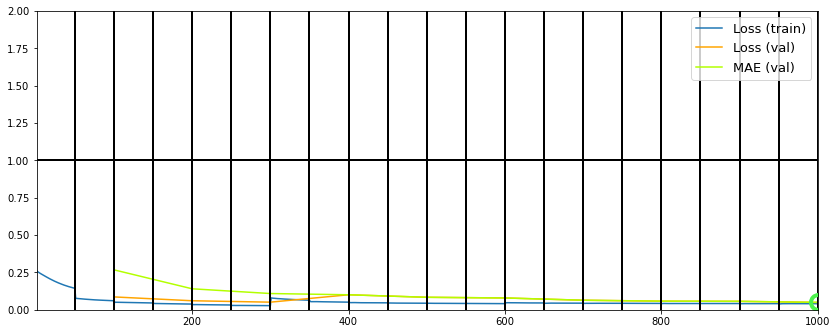

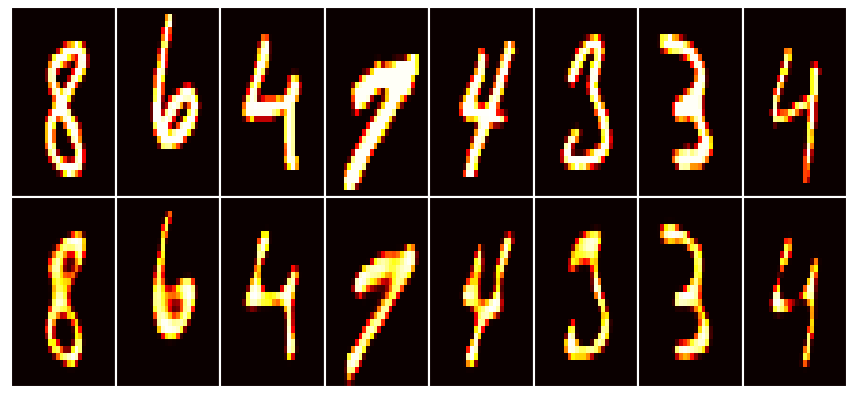

Training has concluded.


In [14]:
tg.train()

In [15]:
cwd = os.getcwd()
print("Checkpoints can be found in", os.path.join(cwd, tg.logdir))
print("Best model can be found in",  os.path.join(cwd, tg.best_models_dir))
print("AE progress can be found in", os.path.join(cwd, tg.logdir, 'misc'))

Checkpoints can be found in C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\logs\M30__model-idp.5-pdp.7-nadam__min.079
Best model can be found in C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\models
AE progress can be found in C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\logs\M30__model-idp.5-pdp.7-nadam__min.079\misc


### Inspect generated logs
Our callback is configured to write images to `tg.logdir + '/misc'`, and there's further the "report" of the train state.<br>
Open the last directory named above, also one of the *previous* model number (since we reinstantiated in Phase 2), to see the callbacks' outputs.<br>
Below we'll look at the last generated report (viewed better by opening the image file):

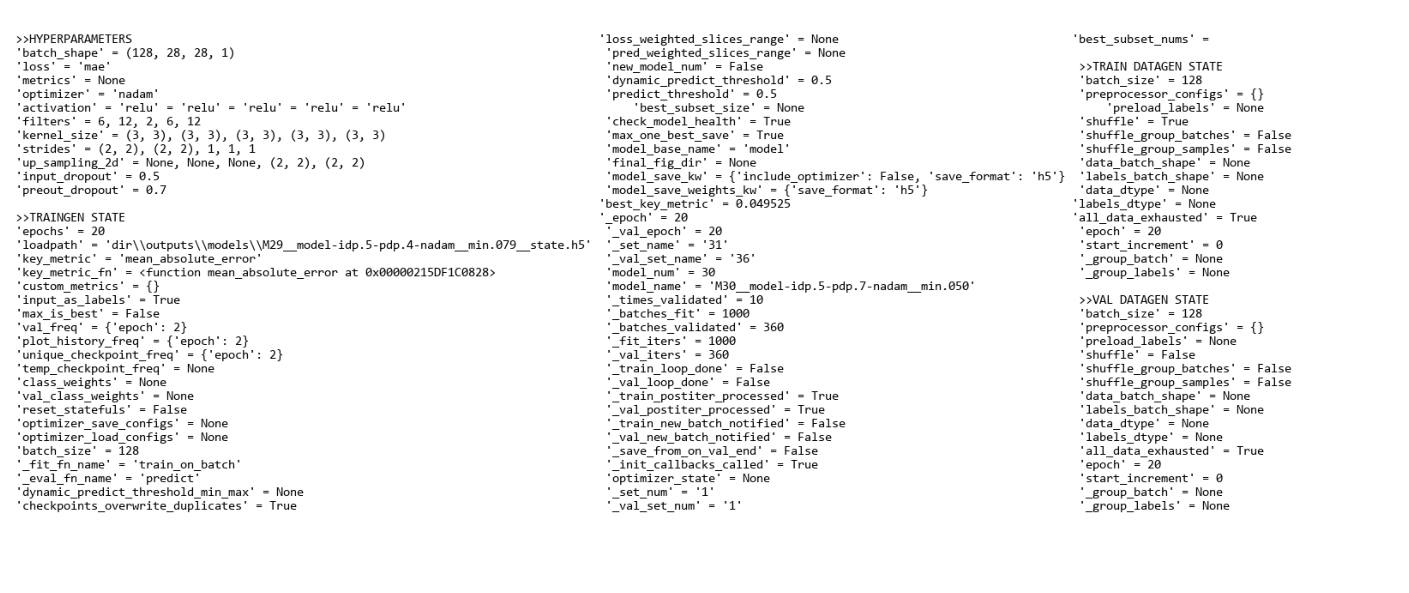

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread(tg.get_last_log('report'))
_, ax = plt.subplots(figsize=(25, 25))
ax.imshow(img)
ax.set_axis_off()
plt.show()

Report generation, including which attributes to include or exclude, is configured in `util/configs.py`, or overridden by the `report_configs` kwarg to `TrainGenerator`. We can configure it to display the most relevant info, and discard the rest. The train state should more completely be saved in the `__state.h5` file, loaded via `tg.load()`.